# Calculating Tensor Perturbation According to Size of Mode


We are using the WKB Theory to account for the radiation to matter transition, this is done a couple of different ways. For long wavelength modes (generally for waves with wavelength much longer than the time taken for a transition to take place) we assume they obey a function like: h_instantaneous, also seen in this paper linked https://arxiv.org/pdf/astro-ph/0412581. For shorter modes we use a modified uniform WKB solution like in Arthur's paper linked https://arxiv.org/pdf/astro-ph/9805173. There is an accompanying written document describing the following function, it is worth mentioning that in the cells below for now we are assuming a **very simplistic** case for now. 

*My goal at the moment is to make sure everything works computationally and most effciently before I plug in real-world numbers. I will also note that because I will be using large values like 1e18 for conformal time today, I am concerned the computation will break.*



In [8]:
import numpy as np
from numpy import sqrt, sin, cos, pi
import matplotlib.pyplot as plt
from scipy import special
import scipy.integrate as integrate
from scipy.integrate import quad
from scipy.integrate import odeint
from scipy.interpolate import CubicSpline
from scipy.integrate import cumtrapz
from scipy.misc import derivative
from scipy.special import airy


In [9]:
def h_instantaneous(k, tau, tau_eq, H0):
    ktau = k * tau
    ktau_eq = k * tau_eq

    # Spherical Bessel Functions
    j0_ktau = np.sin(ktau) / ktau
    j1_ktau = (np.sin(ktau) / ktau) - (np.cos(ktau) / ktau)
    y1_ktau = (-np.cos(ktau) / (ktau ** 2)) - (np.sin(ktau) / ktau)

    A = ((1.5 * ktau_eq - 0.5 * ktau_eq * np.cos(2 * ktau_eq) + np.sin(2 * ktau_eq)) / (ktau_eq ** 2))
    B = ((2 - (2 * (ktau_eq ** 2)) - 2 * np.cos(2 * ktau_eq) - ktau_eq * np.sin(2 * ktau_eq)) / (2 * (ktau_eq ** 2)))

    h_instant = np.where(tau < tau_eq, j0_ktau, (tau_eq / tau) * (A * j1_ktau + B * y1_ktau))

    return h_instant

def u_wkb_uniform(constant, S_star_values, a_star_values, k_range, H0):
    u_values = []
    for i in range(len(k_range)):
        k = k_range[i]
        a_star = a_star_values[i]
        S_star = S_star_values[i]
        
        Q = -1 + ((H0**2/(2*a_star**2))*(omega_matter_today/a_star + 4*omega_lambda_today*(a_star**2)))
        u_k = 2 * np.sqrt(np.pi) * constant * ((3*S_star)/2)**(1/6) * (Q**(-1/4)) * airy(((3*S_star)/2)**(2/3))[0]
        u_values.append(u_k)
    return np.array(u_values)


def S_0(a_star, omega_matter_today, omega_lambda_today, omega_radiation_today):
    def S(x): #defined with variable x
        if x == 0:
            return 0  # Handles the singularity at x = 0
        else:
            return (1/np.sqrt(2)) * np.sqrt(((omega_matter_today/x) + (4*omega_lambda_today*(x**2)))/(omega_radiation_today + (omega_matter_today*x) + (omega_lambda_today*(x**4))))

    # Integrate from a small but finite value (epsilon) to a_star
    epsilon = 1e-3  # Small but finite value
    integral = integrate.quad(S, epsilon, a_star)
    return integral[0]


def combined_h(k, tau, tau_eq, H0, constant, S_star_values, a_star_values, omega_matter_today, omega_lambda_today, omega_radiation_today):
    condition = k / H0 <= 1.55
    h_values = np.where(condition, h_instantaneous(k, tau, tau_eq, H0), u_wkb_uniform(constant, S_star_values, a_star_values, k, H0))
    return h_values


/Users/epmeador/opt/anaconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


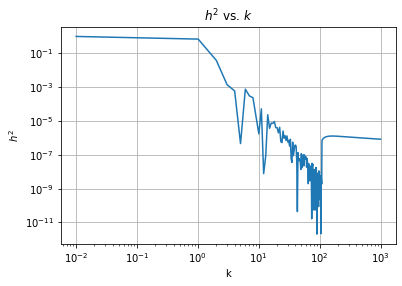

/Users/epmeador/opt/anaconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


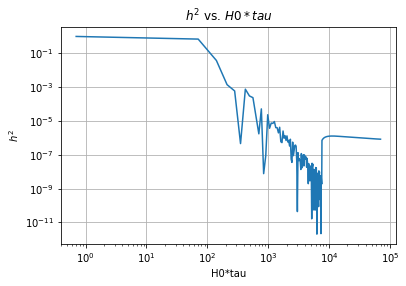

In [10]:


# Constants
H0 = 70  # Hubble constant
tau_eq = 100  # Example value for tau_eq
constant = 1.0  # Example value for constant
omega_matter_today = 0.3  # Example value for omega_matter_today
omega_lambda_today = 0.7  # Example value for omega_lambda_today
omega_radiation_today = 0.0  # Example value for omega_radiation_today

# Generate some k values
k_values = np.linspace(1e-2, 1000, 1000)

# Calculate h^2 for each k
tau_values = np.linspace(1e-2, 1000, 1000)  # Example values for tau

# Calculate a_star based on k
a_star_values = 0.5 * omega_matter_today * H0 / (k_values**2)

# Calculate S_star for each a_star
S_star_values = [S_0(a_star_val, omega_matter_today, omega_lambda_today, omega_radiation_today) for a_star_val in a_star_values]


h_values = combined_h(k_values, tau_values, tau_eq, H0, constant,S_star_values, a_star_values, omega_matter_today, omega_lambda_today, omega_radiation_today)
h_squared_values = h_values**2

# Plot h^2 vs. k
plt.plot(k_values, h_values**2)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('k')
plt.ylabel('$h^2$')
plt.title('$h^2$ vs. $k$')
plt.grid(True)
plt.show()




# Plot h^2 vs. k
plt.plot(H0*tau_values, h_values**2)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('H0*tau')
plt.ylabel('$h^2$')
plt.title('$h^2$ vs. $H0*tau$')
plt.grid(True)
plt.show()